# Predicting Adoption Speed

## Introduction

The purpose of this notebook is to provide an analysis of which types of pets have the toughest time getting adopted. In this analysis we are only studying the adoptions of Dogs and cats.

## Business Understanding

Shelters need to know which pets take the longest time to get adopted, so that they can focus on pushing potential adopters towards those pets.

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix


import warnings

warnings.filterwarnings('ignore')

## Data Understanding

- I cleaned most of the data in the EDA notebook and that data is also included in this repository
- Most of the pets in this dataset have been adopted, thats why the focus is on adoption speed
- The target variable is 'duration of stay' which will be divided into 4 categories

These imports are saved csv files that I made after extensively cleaning the data in the EDA notebook.

In [2]:
cat_df = pd.read_csv('data/cat_df.csv')
dog_df = pd.read_csv('data/dog_df.csv')

In [3]:
dog_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,493.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,137.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,74.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,64.0
4,33,47319,2017-02-05 00:00:00,other,False,NaN,Louise Vada,Pitbull,Black,Dog,4 years 5 months,Female,Stray Dogs Theta,2017-04-05 00:00:00,Reclaimed,NaN,False,NaN,4.0,59.0


In [4]:
dog_df['age(months)'].describe()

count    81.000000
mean      4.617284
std       1.569776
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       6.000000
Name: age(months), dtype: float64

In [5]:
dog_df['movementtype'].value_counts()

Adoption     2841
Reclaimed    1487
Transfer      107
Foster         34
Escaped         1
Name: movementtype, dtype: int64

This model is gonna focus on the dogs that got adopted, and predict how long it takes 

In [6]:
dog_model_data = dog_df[dog_df['movementtype'] == 'Adoption']

In [7]:
dog_model_data['duration of stay'].isna().sum()

0

In [8]:
dog_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,2841.000000,2841.000000,65.000000,2841.000000,2841.000000
mean,8698.644843,62603.009152,5.061538,3.689194,53.449490
std,5244.246966,4842.666952,0.899252,3.221766,118.125138
min,12.000000,46238.000000,2.000000,0.000000,1.000000
25%,4123.000000,58835.000000,5.000000,1.000000,10.000000
50%,8203.000000,62340.000000,5.000000,3.000000,18.000000
75%,12722.000000,66193.000000,6.000000,5.000000,41.000000
max,18667.000000,71690.000000,6.000000,18.000000,1443.000000


Now I want to categorize my target column into these 4 values.

- 0 — Pet was adopted between 1 and 7 days (1st week) after being listed.
- 1 — Pet was adopted between 8 and 30 days (1st month) after being listed.
- 2 — Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 3 — No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [9]:
dog_model_data['duration of stay'][dog_model_data['duration of stay'] <= 7] = 0
dog_model_data['duration of stay'][(dog_model_data['duration of stay'] > 7) & (dog_model_data['duration of stay'] <= 30)] = 1
dog_model_data['duration of stay'][(dog_model_data['duration of stay'] > 30) & (dog_model_data['duration of stay'] <= 90)] = 2
dog_model_data['duration of stay'][dog_model_data['duration of stay'] > 90] = 3

I will ignore this warning in final notebook, but this successfully creates the target column.

In [10]:
dog_model_data['duration of stay'].value_counts()

1.0    1463
2.0     608
0.0     447
3.0     323
Name: duration of stay, dtype: int64

In [11]:
 dog_model_data.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,3.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,3.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,2.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,2.0
7,50,47502,2017-02-27 00:00:00,other,False,981020015101070,Zoey,Pitbull,Grey and White,Dog,5 years 4 months,Female,Stray Dogs Beta,2017-06-01 00:00:00,Adoption,NaN,False,NaN,5.0,3.0


In [12]:
dog_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2841 entries, 0 to 4467
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2841 non-null   int64  
 1   id                2841 non-null   int64  
 2   intakedate        2841 non-null   object 
 3   intakereason      2841 non-null   object 
 4   istransfer        2841 non-null   bool   
 5   identichipnumber  2838 non-null   object 
 6   animalname        2841 non-null   object 
 7   breedname         2840 non-null   object 
 8   basecolour        2841 non-null   object 
 9   speciesname       2841 non-null   object 
 10  animalage         2841 non-null   object 
 11  sexname           2841 non-null   object 
 12  location          2841 non-null   object 
 13  movementdate      2841 non-null   object 
 14  movementtype      2841 non-null   object 
 15  returndate        55 non-null     object 
 16  puttosleep        2841 non-null   bool   


Breedname is missing one value so i will fill it with 'Other'

In [13]:
dog_model_data['breedname'] = dog_model_data['breedname'].fillna('Other')

The months that have missing values means that age will be dictated by the years column, so we can fill the rest of the months column with zeroes, I did the same thing for the years column in my data cleaning notebook before saving the csv. Will be more organized in final notebook.

In [14]:
dog_model_data['age(months)'] = dog_model_data['age(months)'].fillna(0)

## Modeling

### First Simple Model for Dog predictions

In [15]:
dog_model_data.columns

Index(['Unnamed: 0', 'id', 'intakedate', 'intakereason', 'istransfer',
       'identichipnumber', 'animalname', 'breedname', 'basecolour',
       'speciesname', 'animalage', 'sexname', 'location', 'movementdate',
       'movementtype', 'returndate', 'puttosleep', 'age(months)', 'age(years)',
       'duration of stay'],
      dtype='object')

In [16]:
used_cols = ['age(months)', 'age(years)', 'sexname', 'basecolour', 'speciesname', 'breedname', 'intakereason']

In [17]:
X = dog_model_data[used_cols]
y = dog_model_data['duration of stay']

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=42)

In [18]:
#perform a second train_test_split
X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
# Use a for loop to seperate numrical and categorical columns
num_cols =[]
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [20]:
print(num_cols)
print(cat_cols)

['age(months)', 'age(years)']
['sexname', 'basecolour', 'speciesname', 'breedname', 'intakereason']


Create a pipeline to One hot encode categorical values, and scale numerical columns in case we use models that require scaling.

In [21]:
hotencoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(hotencoder)

scaler = StandardScaler()
num_transformer = make_pipeline(scaler)

In [24]:
# Package our encoder into a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols), 
                  ('num', num_transformer, num_cols)], remainder='passthrough')

In [25]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'speciesname',
                                  'breedname', 'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [26]:
X_tr_transformed = preprocessor.fit_transform(X_train)

Our transformed data now has 86 columns.

In [27]:
X_tr_transformed.shape

(1810, 86)

In [28]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'speciesname',
                                  'breedname', 'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [29]:
dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [30]:
cross_val_score(dt_simple_model, X_train, y_train)


array([0.4198895 , 0.4198895 , 0.4281768 , 0.43646409, 0.41160221])

In [34]:
dt_simple_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'speciesname', 'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

In [40]:
dt_test_preds = dt_simple_model.predict(X_test)
dt_train_preds = dt_simple_model.predict(X_train)

print('test precison score', precision_score(y_test, dt_test_preds, average='micro'))
print('test accuracy score', accuracy_score(y_test, dt_test_preds))

print('train precison score', precision_score(y_train, dt_train_preds, average='micro'))
print('train accuracy score', accuracy_score(y_train, dt_train_preds))

test precison score 0.40066225165562913
test accuracy score 0.40066225165562913
train precison score 0.9287292817679558
train accuracy score 0.9287292817679558


Model is severely overfit, some tuning or different model choice is needed.

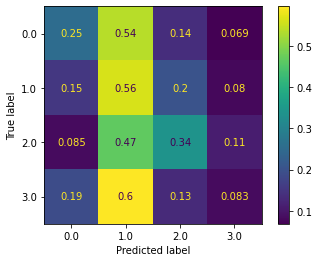

In [35]:
plot_confusion_matrix(dt_simple_model, X_test, y_test, normalize='true')

### Simple Model Evaluation

Remember:

- 0 — Pet was adopted between 1 and 7 days (1st week) after being listed.
- 1 — Pet was adopted between 8 and 30 days (1st month) after being listed.
- 2 — Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 3 — No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


- The model is pretty good at predicting if a dog will take longer than 100 days to adopt
- It is a little over 50 percent accurate at predicting dogs that will be adopted between 8 and 30 days
- But it is pretty bad at predicting if a dog will be adopted in the other 2 ranges

### Future Suggestion

Maybe making this a binary issue might yield better results, such as before or after 30 days possibly.